In [2]:
import os
import math
import pickle
import numpy as np
from math import log
from scipy import signal 
import matplotlib as mpl
from statistics import mean
import matplotlib.pyplot as plt
from scipy.stats import chisquare  # not used yet
from scipy.optimize import leastsq
from collections import defaultdict, OrderedDict

In [3]:
from pylab import rcParams
from cycler import cycler
rcParams['figure.figsize'] = 16, 9
rcParams.update({'figure.max_open_warning': 0, 'font.size': 14, 'axes.titlesize': 14, 'axes.labelsize': 14,
                 'axes.grid':True, 'xtick.direction': 'in', 'ytick.direction': 'in', 'ytick.right': True,
                 'xtick.top':True,'ytick.major.size': 10, 'xtick.major.size': 10, 'legend.fancybox': True,
                 'legend.markerscale': 0.8, 'legend.handlelength': 5.0, 
                 'axes.prop_cycle': cycler('color',
                                           ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']),
                 #'xtick.labelsize': 12,
                 #'ytick.labelsize': 12
                })

mpl.rcParams['grid.linestyle'] = '-.'
#rcParams.keys() 
#plt.style.use('dark_background')
#print(plt.style.available)

In [4]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [5]:
def func(t, a, b, c, d, e):
    return a * (np.exp((414 - t) / b) - np.exp((414 - t) / c)) / (1 / b - 1 / c) + d* (np.exp((414 - t) / b) - np.exp((414 - t) / e)) / (1 / b - 1 / e)
    
    #return d * (np.exp((414 - t) / b) - np.exp((414 - t) / f)) / (1 / b - 1 / f)

    #return a * (np.exp(t / b) - np.exp(t / c)) / (1 / b - 1 / c)

## Model
    A (noise)
    B (amplitude)
    
    \sigma (width)
    \sigma (width)
    \sigma (width)    
\begin{equation*}
f= A \frac{e^{t /\tau_{1}} - e^{t /\tau_{2}}} {{\frac{1}{\tau_{1}}} -{\frac{1}{\tau_{2}}} }  +
B\frac{e^{t /\tau_{3}}} {{\frac{2}{\tau_{1}}} -{\frac{1}{\tau_{3}}} }  
\end{equation*}    

In [14]:
dirname = '/home/furkan/data/april/dope4/'
Run = []
meanWind = np.array([])
meanQrzt = np.array([])
dict_dope = {}
if not os.path.exists('LAr_f'):
    os.makedirs('LAr_f')
for filename in sorted(os.listdir(dirname)):
    if '.pkl' in filename:
            #print(filename)
            with open(dirname+filename,'rb') as fin:
                mydata = pickle.load(fin)

            dict_s ={}
            for key, value in mydata.items():
                
                # filtfilt
                b, a = signal.butter(3, 0.05)
                channel = signal.filtfilt(b, a, value)
                #dict_s.update({key:channel})
                dict_s.update({key:value})
            
            no_window1 = np.mean([dict_s['Ch1'], dict_s['Ch2'], dict_s['Ch3']], axis=0 )
            no_window =no_window1 - no_window1[0:390].mean()
            #dict_s.update({'no_window':no_window})
            
            meanWind = np.hstack((meanWind, no_window,))
            
            
            Quartz1 = ( np.mean([dict_s['Ch4'], dict_s['Ch5'], dict_s['Ch7']], axis=0 ))
            Quartz = Quartz1 - Quartz1[0:390].mean()
            #dict_s.update({'Quartz*1.25':(Quartz)})
            
            meanQrzt = np.hstack((meanQrzt, Quartz,))
            
            LAr = no_window - Quartz 
meanWind = meanWind.reshape(int(meanWind.size / 2000), 2000)
meanQrzt = meanQrzt.reshape(int(meanQrzt.size / 2000), 2000)
meanQrzt = (np.mean(meanQrzt,axis=0))
meanWind = (np.mean(meanWind,axis=0))            

dict_dope.update({'no_window':meanWind})
dict_dope.update({'Quartz*1.25':meanQrzt})
dict_dope.update({'LAr':meanWind - meanQrzt*1.25 })


#with open('dope4.pkl.gz', 'wb') as fin:
#    pickle.dump(dict_dope, fin)
#dict_dope          

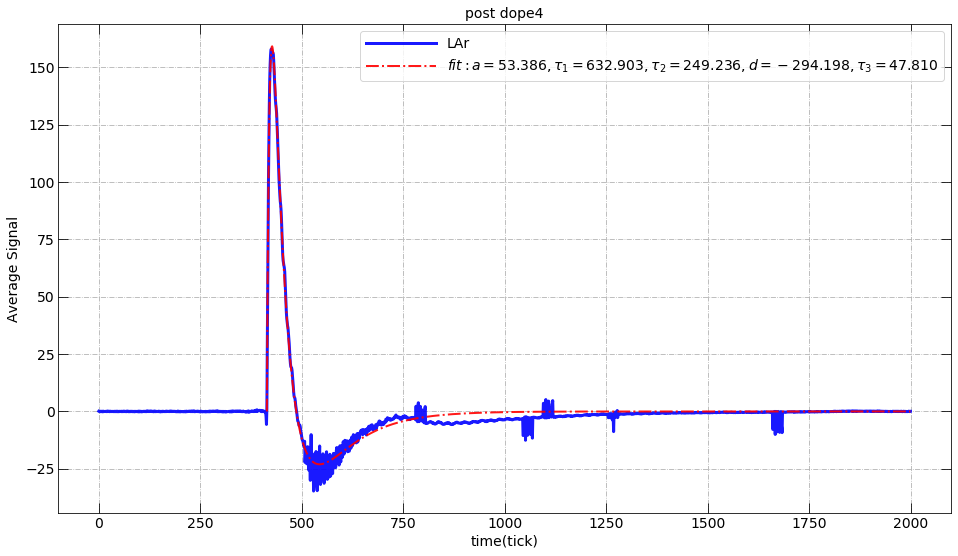

In [15]:
  
for key, value in dict_dope.items():
    #if 'no_window'==key or 'Quartz*1.25'==key or 'LAr'==key:
    if 'LAr'==key:
        ydata = value
        xdata = np.arange(len(ydata))

        #plt.plot(value, label=key, linewidth=2)
        plt.plot(ydata, 'b-', label=key,linewidth=3, alpha=0.9)
        popt, pcov = curve_fit(func, xdata[414:2000], ydata[414:2000], p0=(-10,100,200, -100, 10))
        #if 'no_window'==key or 'Quartz*1.25'==key or 'LAr'==key:
        if 'LAr'==key:    
            plt.plot(xdata[414:2000],func(xdata[414:2000], *popt),
                     'r-.',
                     label=r'$fit: a=%5.3f, \tau_1=%5.3f, \tau_2=%5.3f ,d=%5.3f ,\tau_3=%5.3f$' % tuple(popt*6.7),
                     linewidth=2,
                     alpha=0.9)


#plt.xlim(405,450 )
#plt.yscale('log')
#plt.ylim(0.01, 900)    
plt.legend()
plt.title('post dope4')
plt.xlabel('time(tick)')
plt.ylabel('Average Signal')

plot_path = os.path.abspath('LAr_f') 
plot_name = 'LAr_f'+str(filename.split('.pkl')[0])+'.png'
plt.savefig(os.path.join(plot_path, plot_name))
plt.show()              
            